In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt
import shap
shap.initjs()

In [44]:
index_names = ['unit', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,23)]
col_names = index_names + setting_names + sensor_names
train_df_headers = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
train_df_headers.columns = col_names

In [45]:
train_df_headers.head()

,unit,cycle,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,s_22,s_23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [46]:
# Training data. Failure occurs on the last cycle.

train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
# Test data. Failure occurs on the last cycle.
test_df_headers = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None, names=col_names)
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.dropna(axis=1, inplace=True)

What kind of function does each sensor have?

In [47]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

# Data from the NASA dataset
Column 0 corresponds to the different engine cycles

Column 1 corresponds to the same engine timestamp until failure occured

Column 2-4 correspond to the settings of the engine

Column 5-27 corresond to the different values we got from sensors located in the engine

In [48]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


Column 26 and 27 have no values. We will drop those.

In [49]:
train_df = train_df.drop(columns=[26,27])
test_df = test_df.drop(columns=[26,27])
train_df_headers = train_df_headers.drop(columns=['s_22','s_23'])
test_df_headers = test_df_headers.drop(columns=['s_22','s_23'])
descriptive_stats = train_df.describe(include='all').T
nan_counts = train_df.isna().sum()
zero_counts = (train_df == 0).sum()
summary_df = pd.DataFrame({
    'mean': descriptive_stats['mean'],
    'std': descriptive_stats['std'],
    'nan_count': nan_counts,
    'zero_count': zero_counts
})
print(summary_df)

           mean           std  nan_count  zero_count
0     51.506568  2.922763e+01          0           0
1    108.807862  6.888099e+01          0           0
2     -0.000009  2.187313e-03          0         413
3      0.000002  2.930621e-04          0        2070
4    100.000000  0.000000e+00          0           0
5    518.670000  0.000000e+00          0           0
6    642.680934  5.000533e-01          0           0
7   1590.523119  6.131150e+00          0           0
8   1408.933782  9.000605e+00          0           0
9     14.620000  1.776400e-15          0           0
10    21.609803  1.388985e-03          0           0
11   553.367711  8.850923e-01          0           0
12  2388.096652  7.098548e-02          0           0
13  9065.242941  2.208288e+01          0           0
14     1.300000  0.000000e+00          0           0
15    47.541168  2.670874e-01          0           0
16   521.413470  7.375534e-01          0           0
17  2388.096152  7.191892e-02          0      

We will drop columns with Std very close to 0 or 0 because there is no change in those values and give us no significant information

In [50]:
train_df = train_df.drop(columns=[4,5,9,14,20,22,23])

descriptive_stats = test_df.describe(include='all').T
nan_counts = test_df.isna().sum()
zero_counts = (test_df == 0).sum()
summary_test_df = pd.DataFrame({
    'mean': descriptive_stats['mean'],
    'std': descriptive_stats['std'],
    'nan_count': nan_counts,
    'zero_count': zero_counts
})


test_df = test_df.drop(columns=[4,5,9,14,20,22,23])


/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: invalid value encountered in log
  return lib.map_infer(values, mapper, convert=convert)


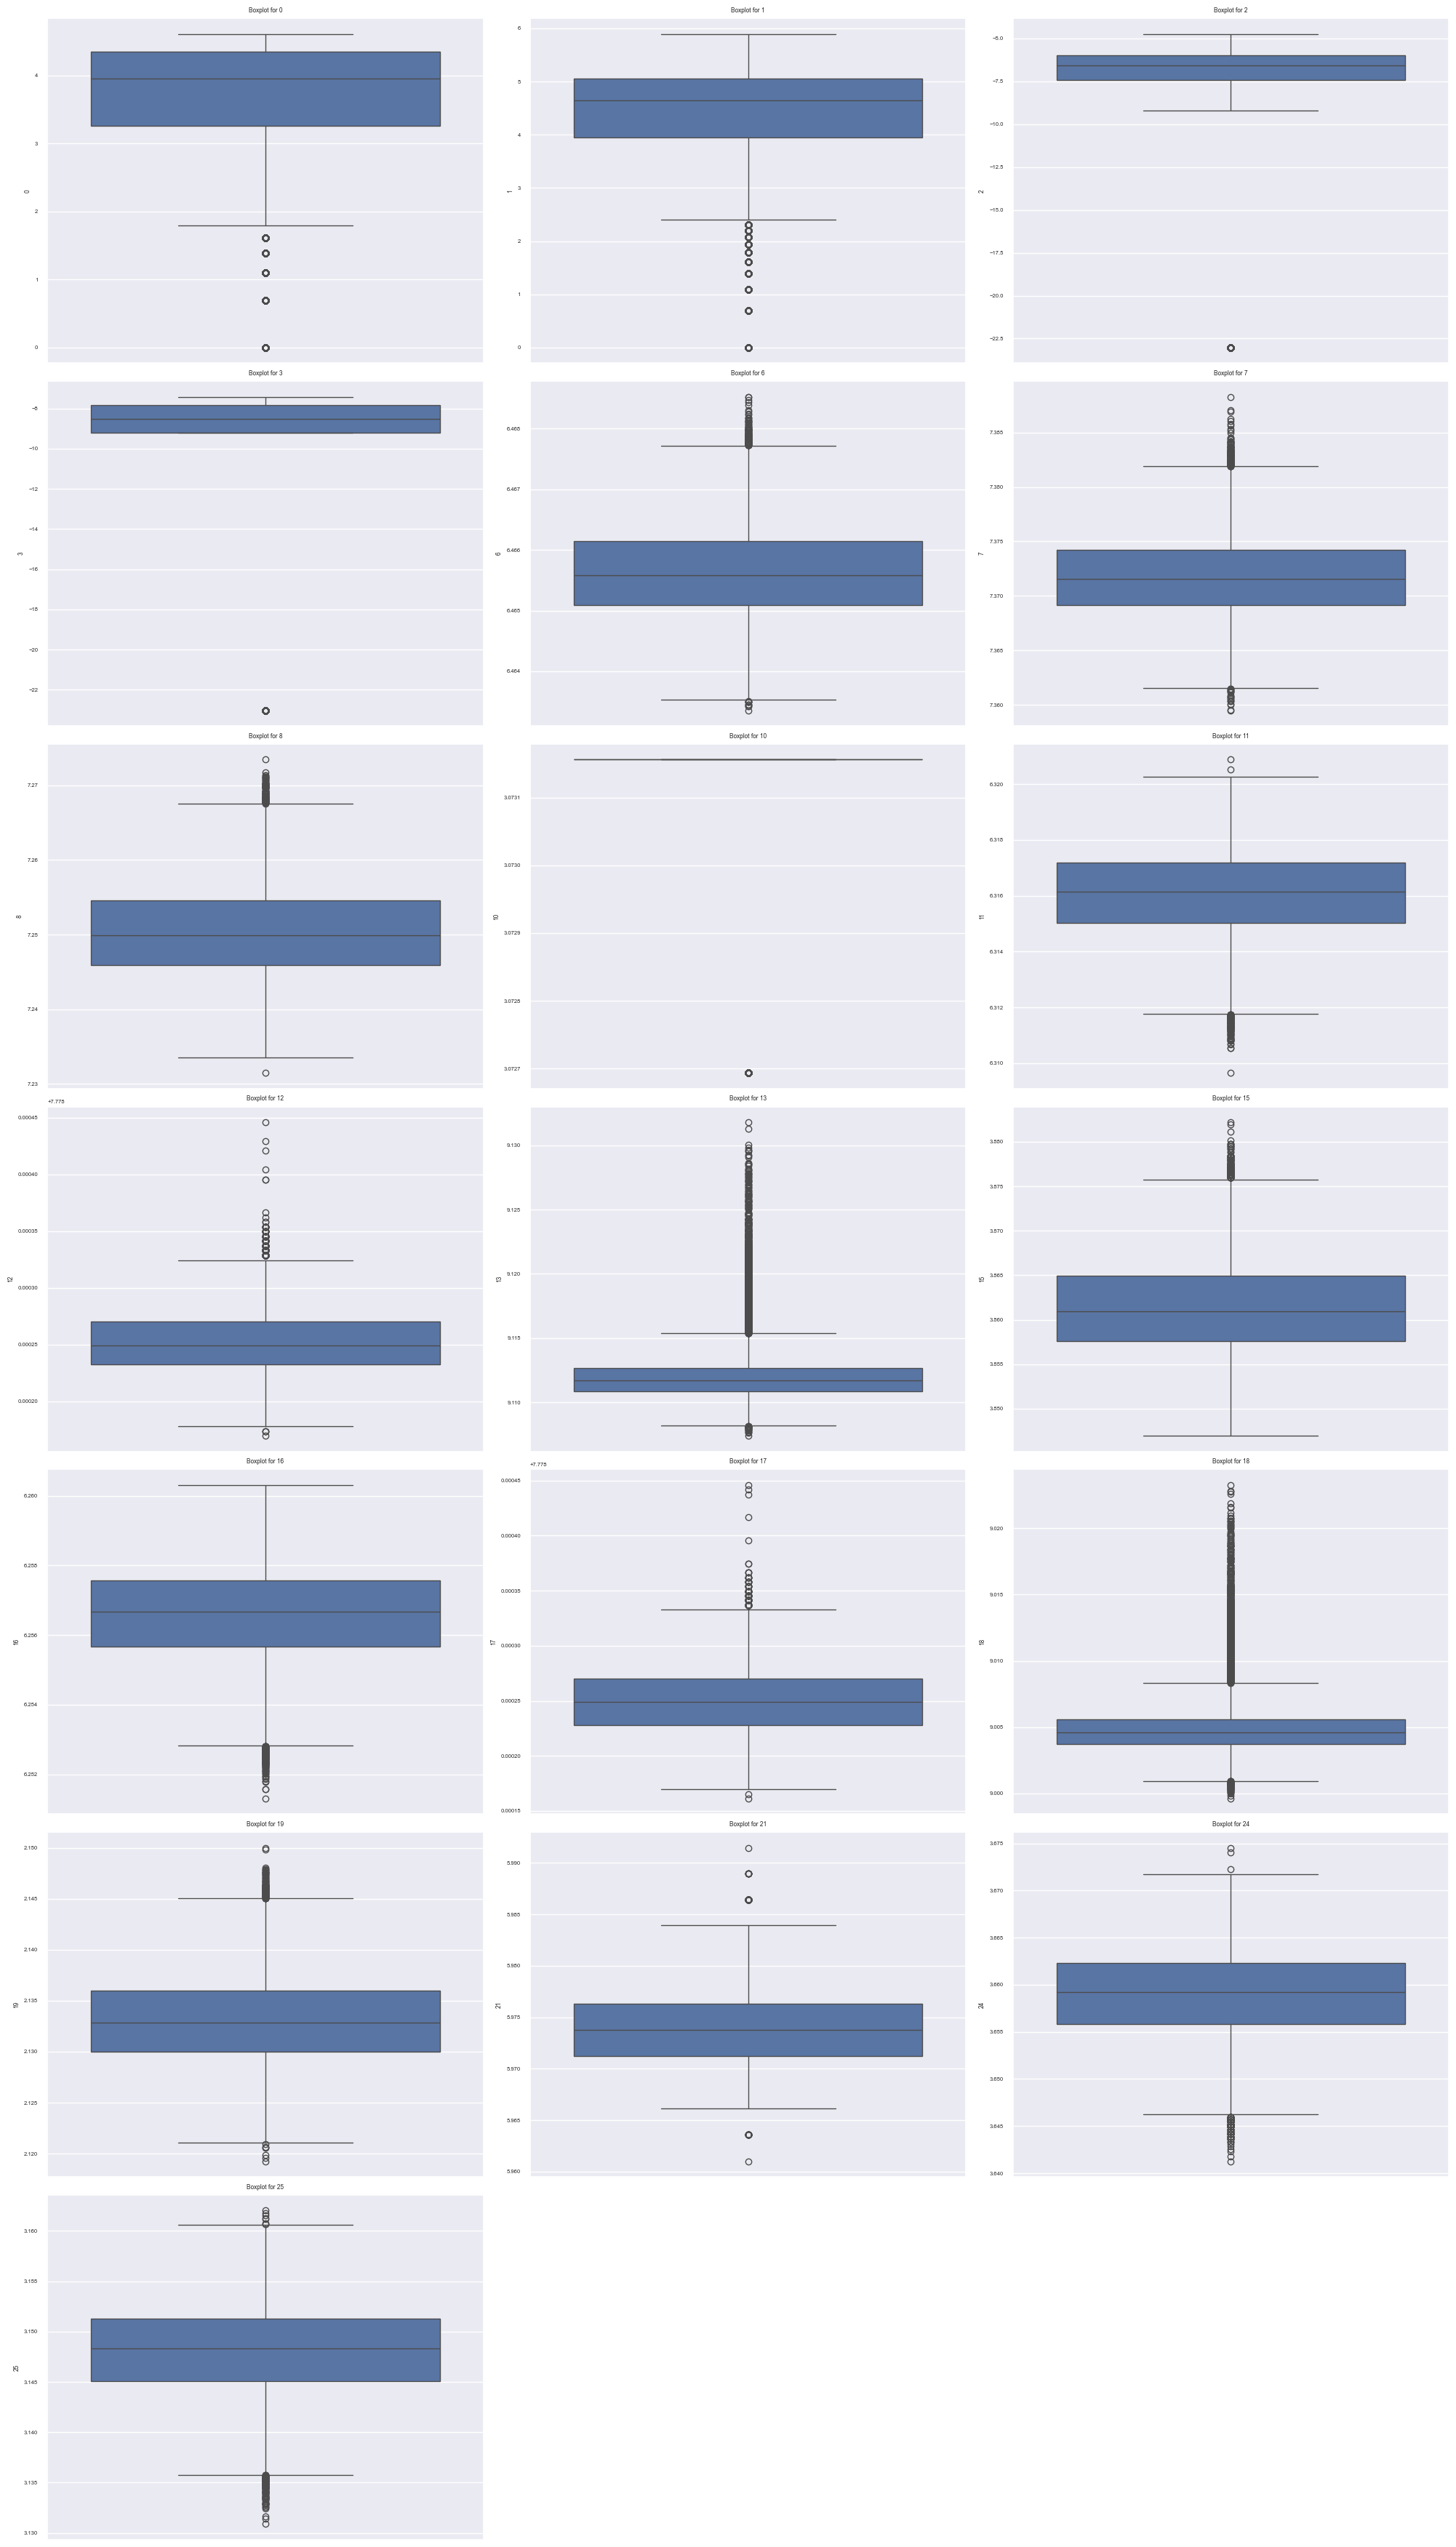

In [51]:
epsilon = 1e-10
df_cleaned = train_df + epsilon
df_log = df_cleaned.map(np.log)


num_columns = df_log.shape[1]
num_rows = (num_columns // 3) + (num_columns % 3 > 0)

fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))

for i, col in enumerate(df_log.columns):
    row = i // 3
    col_idx = i % 3
    sns.boxplot(y=df_log[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot for {col}')

for j in range(i + 1, num_rows * 3):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [52]:
df_result = pd.DataFrame(columns=[0,1])

changes = train_df.iloc[:, 0].ne(train_df.iloc[:, 0].shift()).cumsum()


result_rows = []

for unique_val in changes.unique():
    last_index = changes[changes == unique_val].index[-1]
    result_rows.append({'Case':train_df.iloc[last_index, 0], 'Cycles before failure': train_df.iloc[last_index, 1]})

df_result = pd.DataFrame(result_rows)
df_result

,Case,Cycles before failure
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


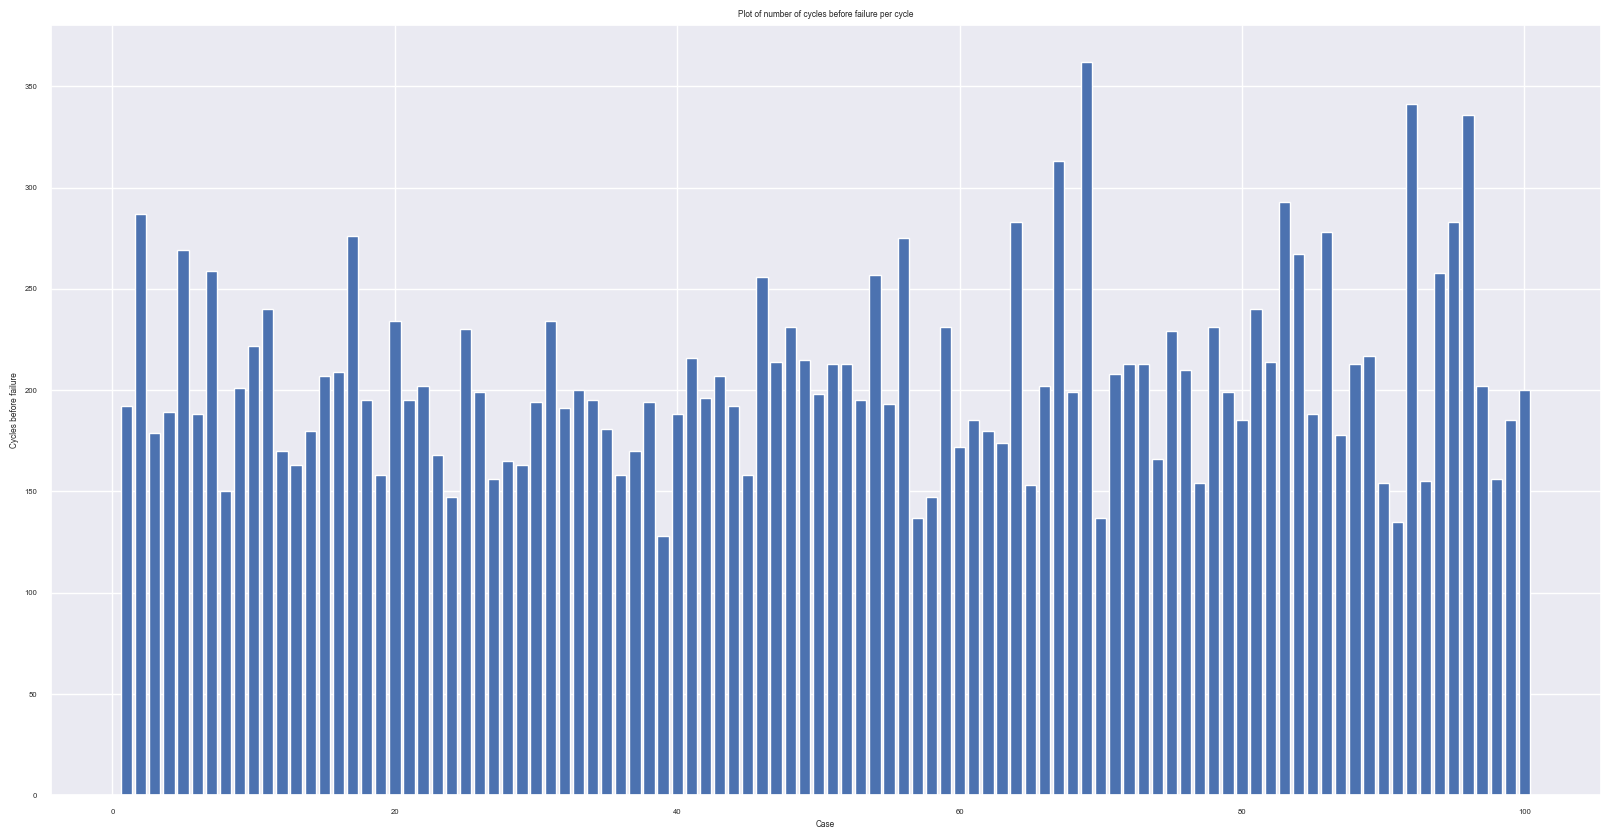

In [53]:
plt.figure(figsize=(20, 10))
plt.bar(df_result['Case'], df_result['Cycles before failure'])

plt.xlabel('Case')
plt.ylabel('Cycles before failure')
plt.title('Plot of number of cycles before failure per cycle')
plt.grid(True)
plt.show()

Correlation matrix 

<Axes: >

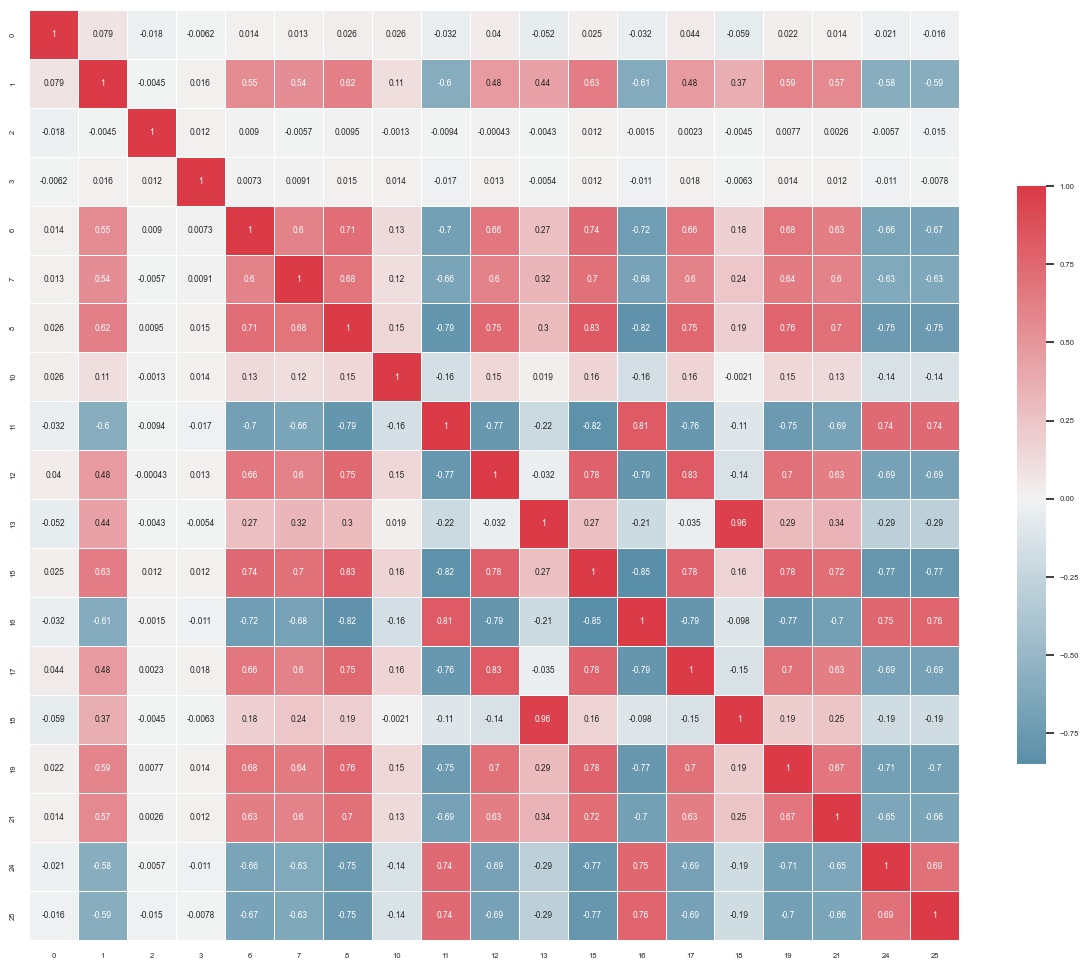

In [54]:
corr = train_df.corr()
sns.set_theme(font_scale=0.5)
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,)

Too many features. K-means doesnt seem to work

### Let's try to work on predicting 50 cycles before the problem arises so we can notify the engineer

In [55]:
rul = pd.DataFrame(train_df.groupby(0)[1].max()).reset_index()

train_df = train_df.merge(rul,how="left", on=[0])

cycles_before_failue = 50

train_df['cbf'] = train_df['1_y'] - train_df['1_x']

rul = pd.DataFrame(train_df_headers.groupby('unit')['cycle'].max()).reset_index()




train_df_headers = train_df_headers.merge(rul,how="left", on=['unit'])
train_df_headers.rename(columns={'cycle_x':'cycle', 'cycle_y':'rul'},inplace=True)
cycles_before_failue = 50

train_df_headers['cbf'] = train_df_headers['rul'] - train_df_headers['cycle']


train_df_headers = train_df_headers.drop(columns=['rul'])


In [56]:
w1 = 30
train_df_headers['failure_within_w1'] = np.where(train_df_headers['cbf'] <= w1, 1, 0 )

w1 = 30
train_df['failure_within_w1'] = np.where(train_df['cbf'] <= w1, 1, 0 )


### Normalize

In [57]:
train_df_headers['cycle_norm'] = train_df_headers["cycle"]

cols_normalize = train_df_headers.columns.difference(['unit','cycle','cbf','failure_within_w1'])

min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df_headers[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df_headers[['unit','cycle','cbf','failure_within_w1']].join(norm_train_df)
train_df_headers = join_df.reindex(columns = train_df_headers.columns)

In [58]:

test_df_headers['cycle_norm'] = test_df_headers['cycle']


norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df_headers[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df_headers.index)


test_join_df = test_df_headers[test_df_headers.columns.difference(cols_normalize)].join(norm_test_df)
test_df_headers = test_join_df.reindex(columns = test_df_headers.columns)
test_df_headers = test_df_headers.reset_index(drop=True)

In [59]:

rul = pd.DataFrame(test_df_headers.groupby('unit')['cycle'].max()).reset_index()
rul.columns = ['unit', 'max']
truth_df.columns = ['additional_rul']


truth_df['unit'] = truth_df.index + 1



truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

test_df_headers = test_df_headers.merge(truth_df, on=['unit'], how='left')
test_df_headers['RUL'] = test_df_headers['max'] - test_df_headers['cycle']
test_df_headers.drop('max', axis=1, inplace=True)

test_df_headers['failure_within_w1'] = np.where(test_df_headers['RUL'] <= w1, 1, 0 )

In [60]:
sequence_length = 50

def sequence_generator(feature_df, seq_length, seq_cols):
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [61]:
def label_generator(label_df, seq_length, label): 
    label_array = label_df[label].values
    num_elements = label_array.shape[0]
    return label_array[seq_length:num_elements, :]

In [62]:
label_gen = [label_generator(train_df_headers[train_df_headers['unit']==id], sequence_length, ['failure_within_w1']) 
             for id in train_df_headers['unit'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)


In [63]:
sensor_cols = ['s_' + str(i) for i in range(1,22)]
# sequence_cols_25 = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm', 'cbf', 'failure_within_w1']
sequence_cols_25 = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) 
print(sequence_cols_25)

['setting_1', 'setting_2', 'setting_3', 'cycle_norm', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [64]:
sequences = []
for unit in train_df_headers['unit'].unique():
    filtered_df = train_df_headers[train_df_headers['unit'] == unit]
    generated_sequences = list(sequence_generator(filtered_df, sequence_length, sequence_cols_25))
    sequences.append(generated_sequences)
    
seq_set_f25 = np.concatenate(list(sequences)).astype(np.float32)
seq_set_f25.shape

(15631, 50, 25)

Epoch 1/200 - Train Loss: 0.6048, Val Loss: 0.5084, Val Accuracy: 0.8095
Epoch 2/200 - Train Loss: 0.5096, Val Loss: 0.4780, Val Accuracy: 0.8095
Epoch 3/200 - Train Loss: 0.4478, Val Loss: 0.3567, Val Accuracy: 0.8095
Epoch 4/200 - Train Loss: 0.3254, Val Loss: 0.2646, Val Accuracy: 0.9169
Epoch 5/200 - Train Loss: 0.2646, Val Loss: 0.2112, Val Accuracy: 0.9284
Epoch 6/200 - Train Loss: 0.2297, Val Loss: 0.1905, Val Accuracy: 0.9284
Epoch 7/200 - Train Loss: 0.2072, Val Loss: 0.1745, Val Accuracy: 0.9361
Epoch 8/200 - Train Loss: 0.1976, Val Loss: 0.1630, Val Accuracy: 0.9450
Epoch 9/200 - Train Loss: 0.1862, Val Loss: 0.1620, Val Accuracy: 0.9437
Epoch 10/200 - Train Loss: 0.1789, Val Loss: 0.1484, Val Accuracy: 0.9501
Epoch 11/200 - Train Loss: 0.1701, Val Loss: 0.1583, Val Accuracy: 0.9335
Epoch 12/200 - Train Loss: 0.1679, Val Loss: 0.1395, Val Accuracy: 0.9501
Epoch 13/200 - Train Loss: 0.1552, Val Loss: 0.1331, Val Accuracy: 0.9565
Epoch 14/200 - Train Loss: 0.1524, Val Loss: 0.

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_60992/960372443.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

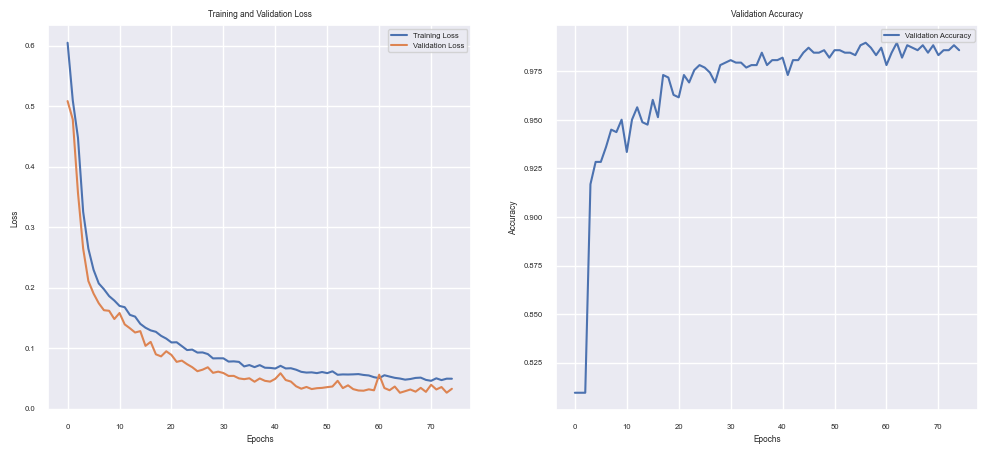

In [65]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x


sequence_length = seq_set_f25.shape[1] 
features_dim = seq_set_f25.shape[2]  
out_dim = label_set.shape[1]  
hidden_dim1 = 10
hidden_dim2 = 5
dropout_prob = 0.2
batch_size = 200

seq_set_f25_tensor = torch.tensor(seq_set_f25, dtype=torch.float32)
label_set_tensor = torch.tensor(label_set, dtype=torch.float32)


dataset = TensorDataset(seq_set_f25_tensor, label_set_tensor)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


model = LSTMModel(features_dim, hidden_dim1, hidden_dim2, out_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
model_path = 'best_model.pth'

train_losses = []
val_losses = []
val_accuracies = []

start = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    train_loss = running_loss / train_size
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

model.load_state_dict(torch.load(model_path))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()




In [66]:
background = seq_set_f25_tensor[:100]
test_data = seq_set_f25_tensor[-100:]

def predict(inputs):
    model.eval()
    with torch.no_grad():
        return model(inputs).detach().cpu().numpy()

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_data)

shap.initjs()
shap.force_plot(np.mean(shap_values[0]), shap_values[0][0], test_data[0].numpy())


In [71]:
# import matplotlib.pyplot as plt
# import shap
# import torch


# background = seq_set_f25_tensor[:100]
# test_data = seq_set_f25_tensor[-50:]

# def predict(inputs):
#     model.eval()
#     with torch.no_grad():
#         return model(inputs).detach().cpu().numpy()

# explainer = shap.GradientExplainer(model, background)
# shap_values = explainer.shap_values(test_data)
# num_instances_to_plot = len(test_data)

# feature_names = [
#     'setting_1', 'setting_2', 'setting_3', 'cycle_norm', "(Fan inlet temperature) (◦R)",
#     "(LPC outlet temperature) (◦R)", "(HPC outlet temperature) (◦R)", "(LPT outlet temperature) (◦R)",
#     "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)", "(HPC outlet pressure) (psia)",
#     "(Physical fan speed) (rpm)", "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)",
#     "(HPC outlet Static pressure) (psia)", "(Ratio of fuel flow to Ps30) (pps/psia)", "(Corrected fan speed) (rpm)",
#     "(Corrected core speed) (rpm)", "(Bypass Ratio)", "(Burner fuel-air ratio)", "(Bleed Enthalpy)",
#     "(Required fan speed)", "(Required fan conversion speed)", "(High-pressure turbines Cool air flow)",
#     "(Low-pressure turbines Cool air flow)"
# ]

# fig, axes = plt.subplots(num_instances_to_plot, 1, figsize=(20, 10 * num_instances_to_plot))


# if num_instances_to_plot == 1:
#     axes = [axes]


# for i in range(num_instances_to_plot):
#     shap_values_instance = shap_values[0][i]
    

#     if len(shap_values_instance.shape) > 1:
#         shap_values_instance = shap_values_instance.flatten()
    

#     axes[i].barh(range(len(shap_values_instance)), shap_values_instance, color='skyblue')
#     axes[i].set_yticks(range(len(feature_names)))
#     axes[i].set_yticklabels(feature_names, fontsize=12)
#     axes[i].set_xlabel('SHAP Value', fontsize=12)
#     axes[i].set_ylabel('Features', fontsize=12)
#     axes[i].set_title(f'SHAP Values for Instance {i}', fontsize=14)
#     axes[i].grid(True, linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()


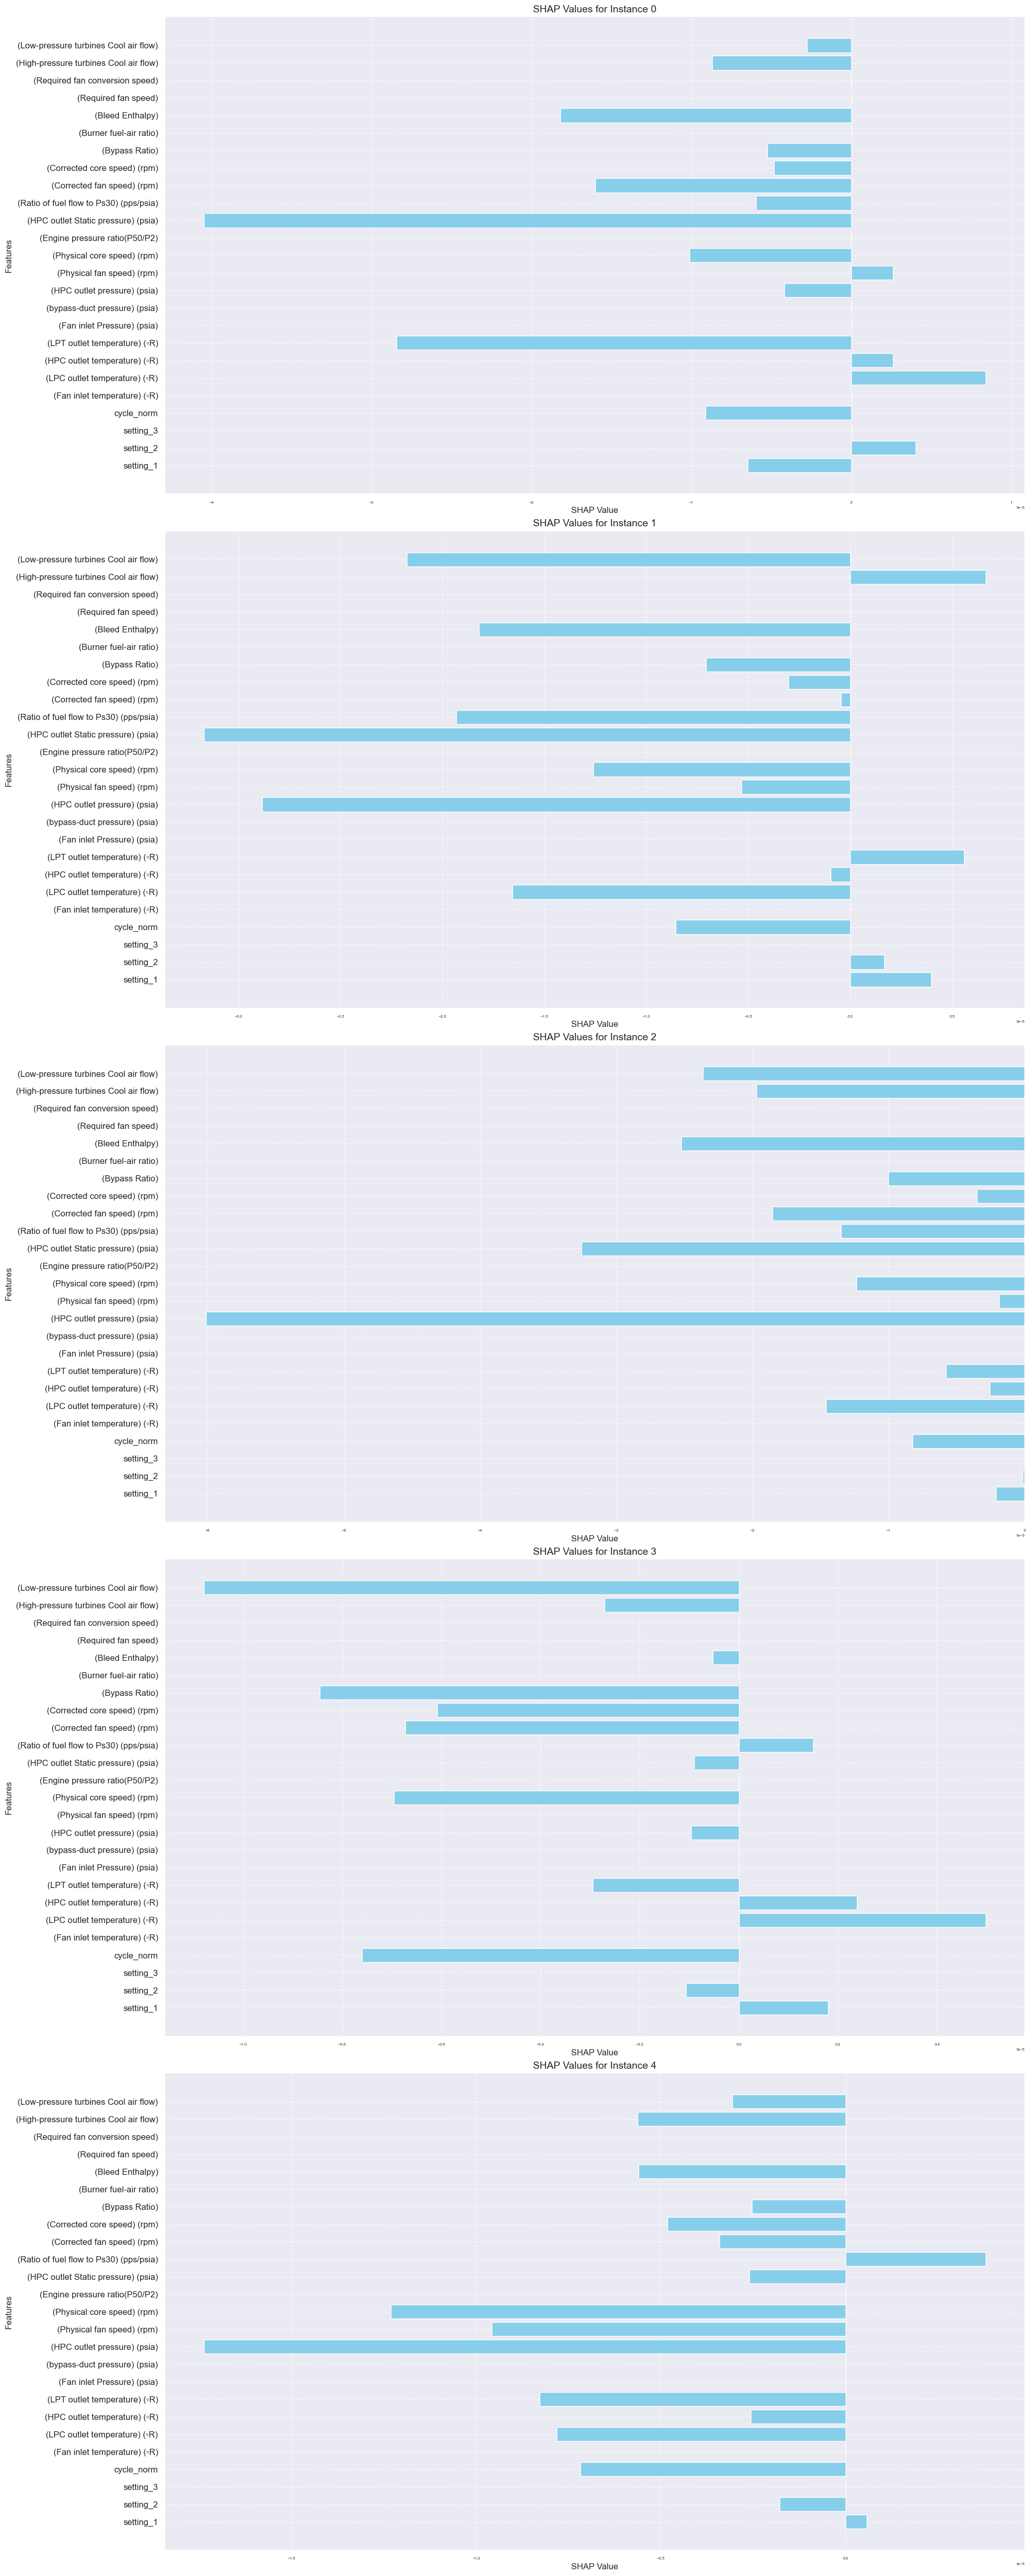

In [72]:
import matplotlib.pyplot as plt
import shap
import torch

background = seq_set_f25_tensor[:100]
test_data = seq_set_f25_tensor[-50:]

def predict(inputs):
    model.eval()
    with torch.no_grad():
        return model(inputs).detach().cpu().numpy()

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_data)

num_instances_to_plot = 5

feature_names = [
    'setting_1', 'setting_2', 'setting_3', 'cycle_norm', "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)", "(HPC outlet temperature) (◦R)", "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)", "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)", "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)",
    "(HPC outlet Static pressure) (psia)", "(Ratio of fuel flow to Ps30) (pps/psia)", "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)", "(Bypass Ratio)", "(Burner fuel-air ratio)", "(Bleed Enthalpy)",
    "(Required fan speed)", "(Required fan conversion speed)", "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"
]

fig, axes = plt.subplots(num_instances_to_plot, 1, figsize=(20, 10 * num_instances_to_plot))

if num_instances_to_plot == 1:
    axes = [axes]

for i in range(num_instances_to_plot):
    shap_values_instance = shap_values[0][i]

    if len(shap_values_instance.shape) > 1:
        shap_values_instance = shap_values_instance.flatten()

    axes[i].barh(range(len(shap_values_instance)), shap_values_instance, color='skyblue')
    axes[i].set_yticks(range(len(feature_names)))
    axes[i].set_yticklabels(feature_names, fontsize=12)
    axes[i].set_xlabel('SHAP Value', fontsize=12)
    axes[i].set_ylabel('Features', fontsize=12)
    axes[i].set_title(f'SHAP Values for Instance {i}', fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [69]:
shap_values.shape

(50, 50, 25, 1)

In [1]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

pipeline = transformers.pipeline(
  "text-generation",
  model="meta-llama/Meta-Llama-3.1-8B-Instruct",
  model_kwargs={"torch_dtype": torch.bfloat16},
  device="cpu",
)

/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]


In [4]:
prompt = "Explain the theory of relativity."
output = pipeline(
    prompt, 
    max_length=50,  
    num_return_sequences=1, 
    truncation=True  
)

print(output[0]['generated_text'])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Explain the theory of relativity. What is its significance and why is it important?
The theory of relativity is a fundamental concept in modern physics that was introduced by Albert Einstein in the early 20th century. It consists of two main


Explain the theory of relativity. Albert
